In [15]:
# data manipulation
import utils
import pandas as pd
import numpy as np

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input, Add, Concatenate
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import model_to_dot
# from keras import backend as K

from IPython.display import SVG

ImportError: cannot import name 'Merge'

In [2]:
X_train = utils.load('X_train')
y_train = utils.load('y_train')

## Tokenize and Encode vocabulary

In [3]:
vocabulary_size = 20000
X_train_stack = utils.clean_questions(utils.stack_questions(X_train))

In [4]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train_stack)

sequences = tokenizer.texts_to_sequences(X_train_stack)
data = pad_sequences(sequences, maxlen=100)

In [5]:
print(data.shape)

(606398, 100)


In [6]:
data[:,0].sum()

7212

Limited the questions to 100 words. 

**Note to self**
* Lemmatization transformation could help
* Not removing numbers

## Embedding Matrix

In [7]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
#     print(word, index, end='\r')
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = utils.nlp(word).vector
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
#     break

## Build out legs of the siamese network

In [22]:
input_shape = (100,)
input_l = Input(input_shape)
input_r = Input(input_shape)

# conv_lstm_net = Sequential()
conv_lstm_net = Embedding(vocabulary_size, 300, input_length=100, weights=[embedding_matrix], trainable=False)
conv_lstm_net.add(Dropout(0.2))
conv_lstm_net.add(Conv1D(64, 5, activation='relu'))
conv_lstm_net.add(MaxPooling1D(pool_size=4))
conv_lstm_net.add(LSTM(300))
conv_lstm_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

encoded_l = conv_lstm_net(input_l)
encoded_r = conv_lstm_net(input_r)

AttributeError: 'Embedding' object has no attribute 'add'

In [17]:
# L1_distance = lambda x: K.abs(x[0]-x[1])
# siamese_net = Sequential()
# siamese_net.add(Concatenate([encoded_l, encoded_r]))
# siamese_net.add(Dense(1,activation='sigmoid'))
# both = merge()
# both = concatenate([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
# prediction = Dense(1,activation='sigmoid')(both)
siamese_net = Model(inputs=[encoded_l,encoded_r],outputs=prediction)
SVG(model_to_dot(siamese_net, show_shapes=True).create(prog='dot', format='svg'))

/anaconda3/envs/project5/lib/python3.6/site-packages/keras/engine/network.py:180: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer sequential_1.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: sequential_1/lstm_1/TensorArrayReadV3:0
  str(x.name))
/anaconda3/envs/project5/lib/python3.6/site-packages/keras/engine/network.py:180: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer sequential_1.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: seq

AssertionError: 

In [24]:
# Creating word embedding layer
embedding_layer = Embedding(vocabulary_size, 300, input_length=100, 
                                     weights=[embedding_matrix], trainable=False)

# Creating LSTM Encoder
# Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm, recurrent_dropout=self.rate_drop_lstm))
lstm_layer = LSTM(300)

# Creating LSTM Encoder layer for First Sentence
sequence_1_input = Input(shape=(100,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

# Creating LSTM Encoder layer for Second Sentence
sequence_2_input = Input(shape=(100,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
x2 = lstm_layer(embedded_sequences_2)



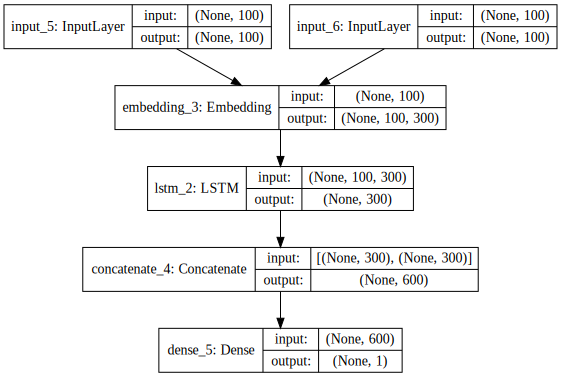

In [25]:
from keras.layers import concatenate
# Merging two LSTM encodes vectors from sentences to
# pass it to dense layer applying dropout and batch normalisation
merged = concatenate([x1, x2])
# merged = BatchNormalization()(merged)
# merged = Dropout(self.rate_drop_dense)(merged)
# merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
# merged = BatchNormalization()(merged)
# merged = Dropout(self.rate_drop_dense)(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Define the batch to pass into the network

In [28]:
odd_idx = [i for i in range(data.shape[0]) if i % 2 == 1]
even_idx = [i for i in range(data.shape[0]) if i % 2 == 0]

train_data_x1 = data[odd_idx[:10000]]
train_data_x2 = data[even_idx[:10000]]
train_labels = y_train[:10000]

val_data_x1 = data[odd_idx[10000:11000]]
val_data_x2 = data[even_idx[10000:11000]]
val_labels = y_train[10000:11000]

In [ ]:
model.fit([train_data_x1, train_data_x2], train_labels,
                  validation_data=([val_data_x1, val_data_x2], val_labels),
                  epochs=10, batch_size=64, shuffle=True)
# ,
#                   callbacks=[early_stopping, model_checkpoint, tensorboard])

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
